In [16]:
import numpy as np

In [17]:
class ConvLayer:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.1
        self.biases = np.zeros((out_channels, 1))
        self.last_input = None

    def forward(self, input):
        self.last_input = input
        in_channels, H, W = input.shape
        H_out = (H - self.kernel_size) // self.stride + 1
        W_out = (W - self.kernel_size) // self.stride + 1

        output = np.zeros((self.out_channels, H_out, W_out))

        for oc in range(self.out_channels):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * self.stride
                    w_start = j * self.stride
                    # патч из входа размером kernel_size x kernel_size
                    patch = input[:, h_start:h_start + self.kernel_size, w_start:w_start + self.kernel_size]
                    output[oc, i, j] = np.sum(patch * self.weights[oc]) + self.biases[oc]
        return output

    def backward(self, d_out, learning_rate):
        input = self.last_input
        in_channels, H, W = input.shape
        H_out, W_out = d_out.shape[1], d_out.shape[2]

        d_input = np.zeros_like(input)
        d_weights = np.zeros_like(self.weights)
        d_biases = np.zeros_like(self.biases)

        for oc in range(self.out_channels):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * self.stride
                    w_start = j * self.stride
                    # патч входа, к которому применяется фильтр
                    patch = input[:, h_start:h_start + self.kernel_size, w_start:w_start + self.kernel_size]
                    # Градиент по весам
                    d_weights[oc] += d_out[oc, i, j] * patch

                    # Градиент по входу
                    d_input[:, h_start:h_start + self.kernel_size, w_start:w_start + self.kernel_size] += (
                            d_out[oc, i, j] * self.weights[oc])

                    # Градиент по смещению
                    d_biases[oc] += d_out[oc, i, j]

        self.weights -= learning_rate * d_weights
        self.biases -= learning_rate * d_biases

        return d_input


In [18]:
class ReLULayer:
    def __init__(self):
        self.last_input = None

    def forward(self, input):
        self.last_input = input
        return np.maximum(0, input)

    def backward(self, d_out):
        d_input = d_out.copy()
        d_input[self.last_input <= 0] = 0
        return d_input

In [19]:
class MaxPoolLayer:
    def __init__(self, pool_size, stride):
        self.pool_size = pool_size
        self.stride = stride

        # для обратного распространения
        self.last_input = None
        self.mask = None

    def forward(self, input):
        self.last_input = input
        channels, H, W = input.shape
        H_out = (H - self.pool_size) // self.stride + 1
        W_out = (W - self.pool_size) // self.stride + 1
        output = np.zeros((channels, H_out, W_out))
        self.mask = {}  # Словарь для хранения координат максимальных элементов в каждом окне

        for c in range(channels):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * self.stride
                    w_start = j * self.stride
                    window = input[c, h_start:h_start + self.pool_size, w_start:w_start + self.pool_size]
                    max_val = np.max(window)
                    output[c, i, j] = max_val
                    # Сохраняем координаты максимума в окне:
                    index = np.unravel_index(np.argmax(window), window.shape)
                    self.mask[(c, i, j)] = (h_start + index[0], w_start + index[1])
        return output

    def backward(self, d_out):
        d_input = np.zeros_like(self.last_input)
        channels_out, H_out, W_out = d_out.shape

        for c in range(channels_out):
            for i in range(H_out):
                for j in range(W_out):
                    # Получаем координаты, где был максимум, для данного окна
                    (h_idx, w_idx) = self.mask[(c, i, j)]
                    # Градиент передаётся только в эту позицию
                    d_input[c, h_idx, w_idx] += d_out[c, i, j]
        return d_input


In [20]:
class AvgPoolLayer:
    def __init__(self, pool_size, stride):
        self.pool_size = pool_size
        self.stride = stride
        self.last_input = None

    def forward(self, input):

        self.last_input = input
        channels, H, W = input.shape
        H_out = (H - self.pool_size) // self.stride + 1
        W_out = (W - self.pool_size) // self.stride + 1

        output = np.zeros((channels, H_out, W_out))
        for c in range(channels):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * self.stride
                    w_start = j * self.stride
                    window = input[c, h_start:h_start + self.pool_size, w_start:w_start + self.pool_size]
                    output[c, i, j] = np.mean(window)
        return output

    def backward(self, d_out):
        input = self.last_input
        channels, H, W = input.shape
        H_out, W_out = d_out.shape[1], d_out.shape[2]
        d_input = np.zeros_like(input)
        pool_area = self.pool_size * self.pool_size
        for c in range(channels):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * self.stride
                    w_start = j * self.stride
                    # Градиент, который равномерно делится на все элементы окна
                    grad = d_out[c, i, j] / pool_area
                    # равномерный вклад ко всем позициям в текущем окне
                    d_input[c, h_start:h_start + self.pool_size, w_start:w_start + self.pool_size] += grad

        return d_input


In [21]:
class FCLayer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(output_size, input_size) * 0.1
        self.biases = np.zeros((output_size, 1))
        self.last_input = None

    def forward(self, input):
        self.last_input = input
        return np.dot(self.weights, input) + self.biases

    def backward(self, d_out, learning_rate):
        # Градиент по весам
        dW = np.dot(d_out, self.last_input.T)
        # Градиент по смещениям
        dB = d_out
        # Градиент по входу, чтобы передать ошибку назад
        d_input = np.dot(self.weights.T, d_out)

        self.weights -= learning_rate * dW
        self.biases -= learning_rate * dB

        return d_input



In [22]:
def softmax(x):
    exp_shifted = np.exp(x - np.max(x))
    return exp_shifted / np.sum(exp_shifted, axis=0)


def cross_entropy_loss(probs, target_index):
    return -np.log(probs[target_index, 0] + 1e-9)  # 1e-9 для числовой стабильности


def softmax_cross_entropy_backward(probs, target_index):
    grad = probs.copy()
    grad[target_index] -= 1
    return grad

In [23]:
class Lenet5:
    def __init__(self):
        self.flat_shape = None
        self.conv1 = ConvLayer(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.relu1 = ReLULayer()
        self.pool1 = MaxPoolLayer(pool_size=2, stride=2)
        self.conv2 = ConvLayer(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.relu2 = ReLULayer()
        self.pool2 = MaxPoolLayer(pool_size=2, stride=2)
        self.fc1 = FCLayer(input_size=16 * 5 * 5, output_size=120)
        self.relu3 = ReLULayer()
        self.fc2 = FCLayer(input_size=120, output_size=84)
        self.relu4 = ReLULayer()
        self.fc3 = FCLayer(input_size=84, output_size=10)

    def forward(self, x):
        out = self.conv1.forward(x)
        out = self.relu1.forward(out)
        out = self.pool1.forward(out)
        out = self.conv2.forward(out)
        out = self.relu2.forward(out)
        out = self.pool2.forward(out)
        self.flat_shape = out.shape
        out_flat = out.reshape(-1, 1)
        out = self.fc1.forward(out_flat)
        out = self.relu3.forward(out)
        out = self.fc2.forward(out)
        out = self.relu4.forward(out)
        out = self.fc3.forward(out)
        probs = softmax(out)
        return probs

    def backward(self, d_loss, learning_rate):
        d_out = self.fc3.backward(d_loss, learning_rate)
        d_out = self.relu4.backward(d_out)
        d_out = self.fc2.backward(d_out, learning_rate)
        d_out = self.relu3.backward(d_out)
        d_out = self.fc1.backward(d_out, learning_rate)
        d_out = d_out.reshape(self.flat_shape)
        d_out = self.pool2.backward(d_out)
        d_out = self.relu2.backward(d_out)
        d_out = self.conv2.backward(d_out, learning_rate)
        d_out = self.pool1.backward(d_out)
        d_out = self.relu1.backward(d_out)
        d_out = self.conv1.backward(d_out, learning_rate)
        return d_out

In [24]:
def softmax_crossentropy_with_logits(logits, labels):
    exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probs = exps / np.sum(exps, axis=1, keepdims=True)
    loss = -np.mean(np.sum(labels * np.log(probs + 1e-9), axis=1))
    return loss, probs


def grad_softmax_crossentropy(probs, labels):
    return (probs - labels) / labels.shape[0]

In [25]:
from keras.api.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_X = train_X.astype(np.float32) / 255.0
test_X = test_X.astype(np.float32) / 255.0

# Изменяем форму изображений (N, 28, 28) -> (N, 1, 28, 28) (1 канал)
train_X = np.expand_dims(train_X, axis=1)
test_X = np.expand_dims(test_X, axis=1)

# Изменяем размер изображений с 28x28 до 32x32 (2 пикселя с каждой стороны)
train_X = np.pad(train_X, ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant')
test_X = np.pad(test_X, ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant')

train_X = train_X[:700]
test_X = test_X[:100]
train_y = train_y[:700]
test_y = test_y[:100]


In [26]:
def evaluate(model, test_X, test_y) -> (float, float):
    epoch_loss = 0
    epoch_acc = 0
    for index, image in enumerate(test_X):
        probs = model.forward(image)
        true_class = test_y[index]
        loss = cross_entropy_loss(probs, true_class)
        epoch_loss += loss
        probs = probs.ravel()
        prediction = np.argmax(probs)
        if prediction == true_class:
            epoch_acc += 1
    return epoch_loss / len(test_X), epoch_acc / len(test_X) * 100


In [27]:

from tqdm import tqdm

net = Lenet5()
learning_rate = 0.01
losses = []
accuracies = []

num_epochs = 10

for epoch in range(num_epochs):

    for index, image in tqdm(enumerate(train_X)):
        probs = net.forward(image)
        true_class = train_y[index]
        loss = cross_entropy_loss(probs, true_class)
        d_loss = softmax_cross_entropy_backward(probs, true_class)
        net.backward(d_loss, learning_rate)

    epoch_loss, epoch_acc = evaluate(net, test_X, test_y)
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)


0it [00:00, ?it/s]C:\Users\anzhi\AppData\Local\Temp\ipykernel_14764\3882278345.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[oc, i, j] = np.sum(patch * self.weights[oc]) + self.biases[oc]
700it [01:20,  8.74it/s]
700it [01:18,  8.96it/s]
700it [01:19,  8.82it/s]
700it [01:19,  8.77it/s]
700it [01:20,  8.74it/s]
700it [01:20,  8.72it/s]
700it [01:19,  8.78it/s]
700it [01:20,  8.73it/s]
700it [01:20,  8.68it/s]
700it [01:20,  8.69it/s]


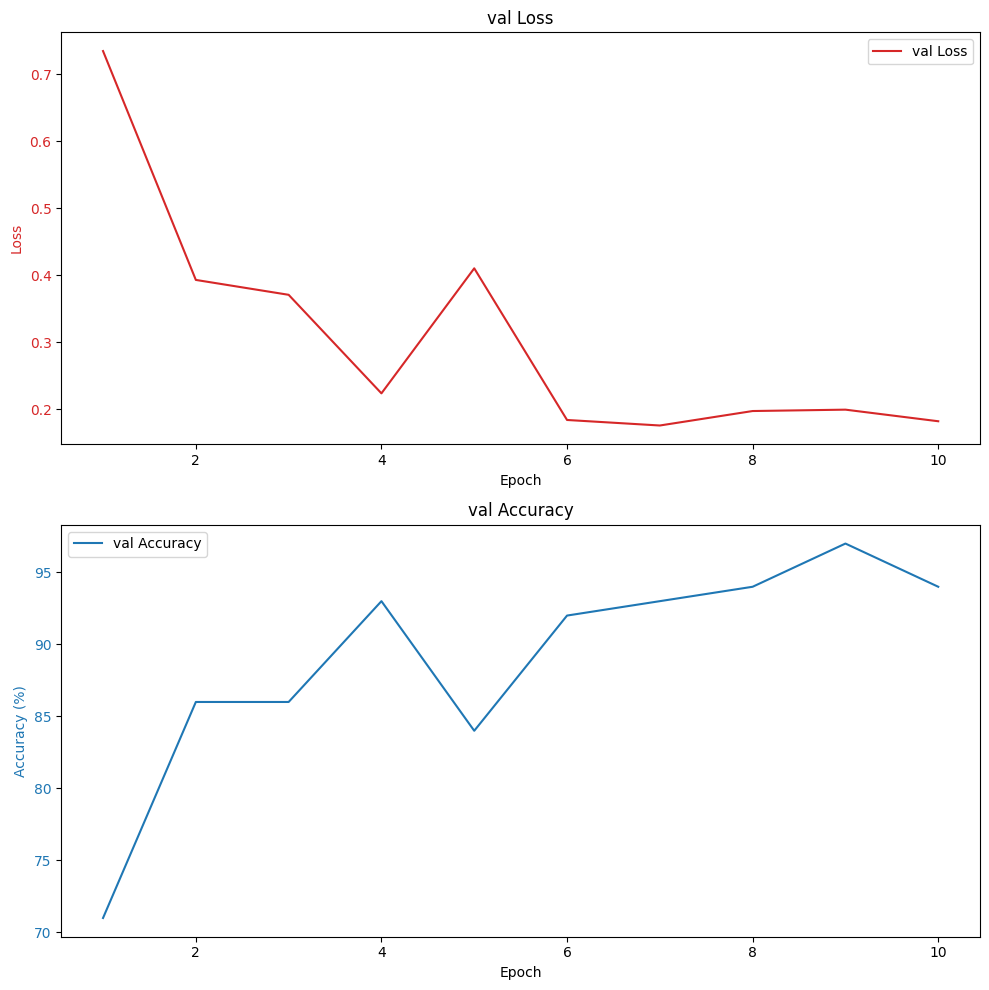

In [28]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, len(losses) + 1), losses, color=color, label='val Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper right')
ax1.set_title("val Loss")

color = 'tab:blue'
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(range(1, len(accuracies) + 1), accuracies, color=color,
         label='val Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper left')
ax2.set_title("val Accuracy")

plt.tight_layout()
plt.show()


0it [00:00, ?it/s]C:\Users\anzhi\AppData\Local\Temp\ipykernel_14764\3882278345.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[oc, i, j] = np.sum(patch * self.weights[oc]) + self.biases[oc]
100it [00:05, 17.74it/s]


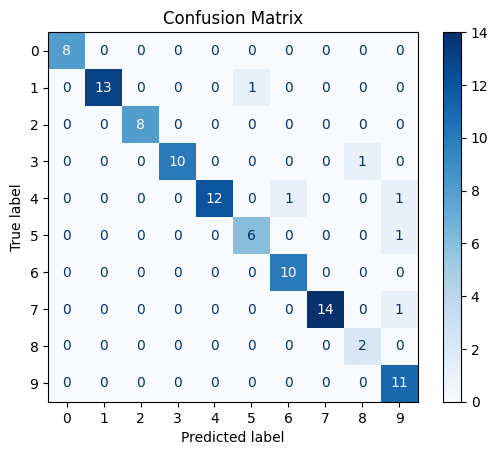

In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_classes = []
pred_classes = []
for index, image in tqdm(enumerate(test_X)):
    probs = net.forward(image)
    true_class = test_y[index]
    pred_class = np.argmax(probs)
    pred_classes.append(pred_class)
    true_classes.append(true_class)

true_classes = np.array(true_classes)

cm = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()